In [2]:
import numpy as np
import shapely
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
from rasterio.windows import Window as rWindow
from rasterio.enums import Resampling
from dea import xr_vectorize
from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)

from typing import List, Any
import os
import cv2
import pyproj
import pandas as pd

d:\OneDrive\02_Standards\[Code]\01_Projects\ASRP_Antarctic-Remote-Sensing-1\.venv_ASRP\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
from sgl_processor_v02 import ProcessorSGL, ProcessorSGLOptions, Window, WindowCollection
from sgl_utils import ROI, ROICollection, Window, WindowCollection, RES, date_with_comma
from sgl_utils import get_angle, cmap_clouds, cmap_ice, find_drainages, drainage2vector, window_dataset
import geopandas as gpd

In [4]:
optionsSGL = ProcessorSGLOptions()
optionsSGL.rangestart = "20191201"
optionsSGL.rangeend = "20200331"
processorSGL = ProcessorSGL(optionsSGL)

X=====================================================
PostProcessor started for 20191201 to 20200331
X=====================================================


In [5]:
metas = processorSGL.get_metadata_from_csv(processorSGL.opts.output_folder, ["tile-181", "tile-182", "tile-183"])
coll = processorSGL.create_collection_from_meta("shackleton1920", metas)

=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.


In [6]:
rcoll = processorSGL.create_roicollection_from_csv("shackleton")

     | 16 regions created.


In [6]:
images, included_windows = processorSGL.create_clipped_images(coll, max_images = 30, roi = rcoll.get("E"), satellites = ["S2", "L8"], dominant_satellite = "S2", print_metadata = True, show_bool = False, return_windows = True)

=====> Create Images
     | 2019-12-05 | L8
     | 2019-12-06 | S2
     | 2019-12-13 | L8
     | 2019-12-16 | S2
     | 2019-12-21 | L8
     | 2019-12-26 | S2
     | 2019-12-29 | L8
     | 2020-01-05 | S2
     | 2020-01-06 | L8
     | 2020-01-14 | L8
     | 2020-01-15 | S2
     | 2020-01-22 | L8
     | 2020-01-25 | S2
     | 2020-01-30 | L8
     | 2020-02-04 | S2
     | 2020-02-07 | L8
     | 2020-02-14 | S2
     | 2020-02-15 | L8
     | 2020-02-23 | L8
     | 2020-02-24 | S2
     | 2020-03-02 | L8
     | 2020-03-05 | S2
     | 2020-03-10 | L8
     | 2020-03-15 | S2


In [7]:
print(images.keys())

dict_keys(['rgb', 'lakes', 'clouds', 'noclouds', 'depth', 'dmg', 'dmg transform', 'lakeextent', 'transform', 'dmg resampled'])


In [8]:
dates = [w.metadata["date"] for w in included_windows]
d0 = "2020-01-22"
d1 = "2020-01-30"
d2 = "2020-02-07"

w0 = [w for w in included_windows if w.metadata["date"] == d0 and w.satellite == "L8"][0]
w1 = [w for w in included_windows if w.metadata["date"] == d1 and w.satellite == "L8"][0]
w2 = [w for w in included_windows if w.metadata["date"] == d2 and w.satellite == "L8"][0]

clouds0 = [i for (d, i) in zip(dates, images["clouds"]) if d == d0][0]
clouds1 = [i for (d, i) in zip(dates, images["clouds"]) if d == d1][0]
clouds2 = [i for (d, i) in zip(dates, images["clouds"]) if d == d2][0]

noclouds0 = [i for (d, i) in zip(dates, images["noclouds"]) if d == d0][0]
noclouds1 = [i for (d, i) in zip(dates, images["noclouds"]) if d == d1][0]
noclouds2 = [i for (d, i) in zip(dates, images["noclouds"]) if d == d2][0]

lakes0 = [i for (d, i) in zip(dates, images["lakes"]) if d == d0][0]
lakes1 = [i for (d, i) in zip(dates, images["lakes"]) if d == d1][0]
lakes2 = [i for (d, i) in zip(dates, images["lakes"]) if d == d2][0]

depth0 = [i for (d, i) in zip(dates, images["depth"]) if d == d0][0]
depth1 = [i for (d, i) in zip(dates, images["depth"]) if d == d1][0]
depth2 = [i for (d, i) in zip(dates, images["depth"]) if d == d2][0]

<AxesSubplot: >

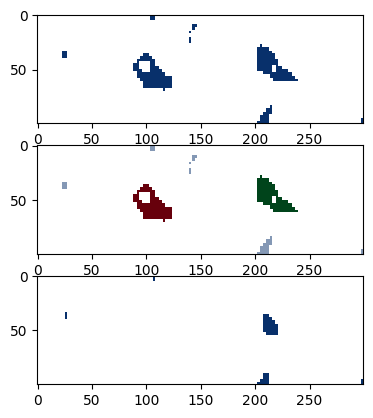

In [10]:
rw0 = window_dataset(lakes0, images["transform"], 2.555e6, -4.445e5, 2.558e6, -4.435e5)[0]
rw1 = window_dataset(lakes1, images["transform"], 2.555e6, -4.445e5, 2.558e6, -4.435e5)[0]
#drain_rpt = find_drainages(lakes0  * noclouds1, lakes1, min_lake_pixel_size= 20)
drain_rpt = find_drainages(rw0, rw1, min_lake_pixel_size= 200, min_shrink=0.6)
fig, axes = plt.subplots(3, 1)

ax = axes[0]
rplt.show(rw0, ax = ax, cmap = "Blues_r")

ax = axes[1]
rplt.show(rw0, ax = ax, alpha = 0.5, cmap = "Blues_r")
drain_image = drain_rpt["drain"]
drain_image[drain_image == 0] = np.nan
rplt.show(rw0 * drain_image, ax = ax, cmap = "Reds_r")
shrink_image = drain_rpt["shrink0"]
shrink_image[shrink_image == 0] = np.nan
rplt.show(rw0 * shrink_image, ax = ax, cmap = "Greens_r")

ax = axes[2]
rplt.show(rw1, cmap = "Blues_r", ax = ax)

[129]
[ 46 124 136]


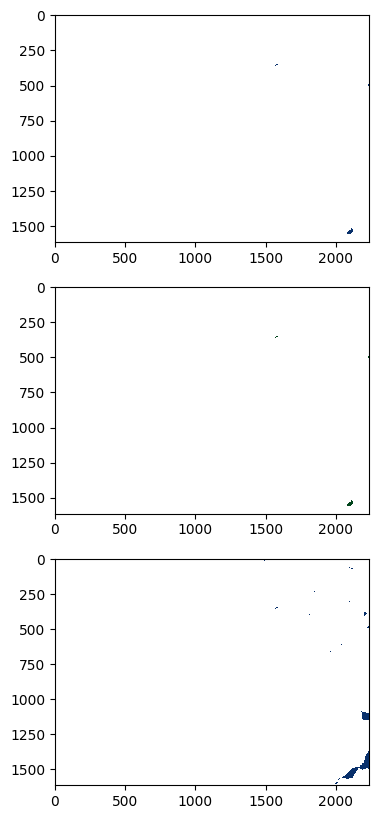

In [22]:
drain_rpt = find_drainages(lakes0 * noclouds0, lakes1, min_lake_pixel_size= 200, min_shrink=0.8)
fig, axes = plt.subplots(3, 1, figsize= (30, 10))


ax = axes[0]
rplt.show(lakes0, ax = ax, cmap = "Blues_r")

ax = axes[1]
rplt.show(lakes0, ax = ax, alpha = 0.5, cmap = "Blues_r")
rplt.show(lakes0 * drain_rpt["drain"], ax = ax, cmap = "Reds_r")
rplt.show(lakes0 * drain_rpt["shrink0"], ax = ax, cmap = "Greens_r")

ax = axes[2]
rplt.show(lakes1, cmap = "Blues_r", ax = ax)
print(drain_rpt["missing_lake_ids"])
print(drain_rpt["shrinking_lake_ids"])

In [7]:
dmgs = processorSGL.get_vectorized_dmgs(coll, print_bool = True, min_dmg_threshold = 0.0, category_bins=11)

=====> Get vectorized dmg.
     |  24156 |tile-181_S1_20191101_20191110_30m_output_10px_dmg.tif
     |  22917 |tile-182_S1_20191101_20191110_30m_output_10px_dmg.tif
     |  15683 |tile-183_S1_20191101_20191110_30m_output_10px_dmg.tif


In [8]:
lakeextents = processorSGL.get_vectorized_lakeextents(coll, print_bool = True)

=====> Get vectorized max lake extents.
     |  38659 |tile-181_L8S2_2019-12-01_2020-03-31_10m_maxlake.tif
     |   6131 |tile-182_L8S2_2019-12-01_2020-03-31_10m_maxlake.tif
     |    995 |tile-183_L8S2_2019-12-01_2020-03-31_10m_maxlake.tif


In [60]:
def ckdnearest_DfromSGL(gdD, gdSGL):
    gdD = gdD.reset_index(drop=True).rename(columns = {"attribute": "dmg", "geometry" : "dmg-geometry"})
    #gdD['dmg-category'] = gdD['dmg'].apply(dmg_categorize)
    gdSGL = gdSGL.reset_index(drop=True)
    #print(gdSGL.shape, gdD.shape)
    nSGL = np.array(list(gdSGL["centroids"].apply(lambda x: (x.x, x.y))))
    nD = np.array(list(gdD["centroids"].apply(lambda x: (x.x, x.y))))
    #print(nSGL.shape , nD.shape)
    SGLtree = cKDTree(nSGL)
    dist, idx = SGLtree.query(nD, k=1)
    #print(min(dist), max(idx))
    
    gdSGL_nearest = gdSGL.iloc[idx].rename(columns={"geometry" : "sgl-geometry", "centroids" : "sgl-centroids"}).reset_index(drop=True)
    gdf = pd.concat(
        [
            gdD.reset_index(drop=True),
            pd.Series(dist, name='dist-lake-dmg'),
            gdSGL_nearest,
            
        ], 
        axis=1)
    

    return gdf

In [41]:
gdf_DfromSGL = ckdnearest_DfromSGL(dmgs[0]["data"], lakeextents[0]["data"])

In [42]:
gdf_DfromSGL.head()

,dmg,dmg-geometry,centroids,dist-lake-dmg,sgl-geometry,sgl-centroids
0,1.0,"POLYGON ((2549895.000 -464625.000, 2549895.000...",POINT (2550345.000 -464775.000),3590.741567,"POLYGON ((2551120.000 -468270.000, 2551120.000...",POINT (2551125.000 -468280.000)
1,1.0,"POLYGON ((2553795.000 -464625.000, 2553795.000...",POINT (2554245.000 -464775.000),2643.638591,"POLYGON ((2556800.000 -465410.000, 2556800.000...",POINT (2556810.000 -465415.000)
2,1.0,"POLYGON ((2555295.000 -464625.000, 2555295.000...",POINT (2555445.000 -464775.000),1507.589135,"POLYGON ((2556800.000 -465410.000, 2556800.000...",POINT (2556810.000 -465415.000)
3,1.0,"POLYGON ((2555895.000 -464625.000, 2555895.000...",POINT (2556045.000 -464775.000),997.409144,"POLYGON ((2556800.000 -465410.000, 2556800.000...",POINT (2556810.000 -465415.000)
4,2.0,"POLYGON ((2556195.000 -464625.000, 2556195.000...",POINT (2556345.000 -464775.000),791.091019,"POLYGON ((2556800.000 -465410.000, 2556800.000...",POINT (2556810.000 -465415.000)


C:\Users\js-ms\AppData\Local\Temp\ipykernel_22180\2341242111.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  gdf_DfromSGL.hist(column = "dist-lake-dmg", bins = list(np.arange(0, max_dist, 300 / 2)), by = "dmg", ax = ax, sharex = True, log = True, sharey = True, layout = (2, 4))


array([[<AxesSubplot: title={'center': 'dist-lake-dmg'}>]], dtype=object)

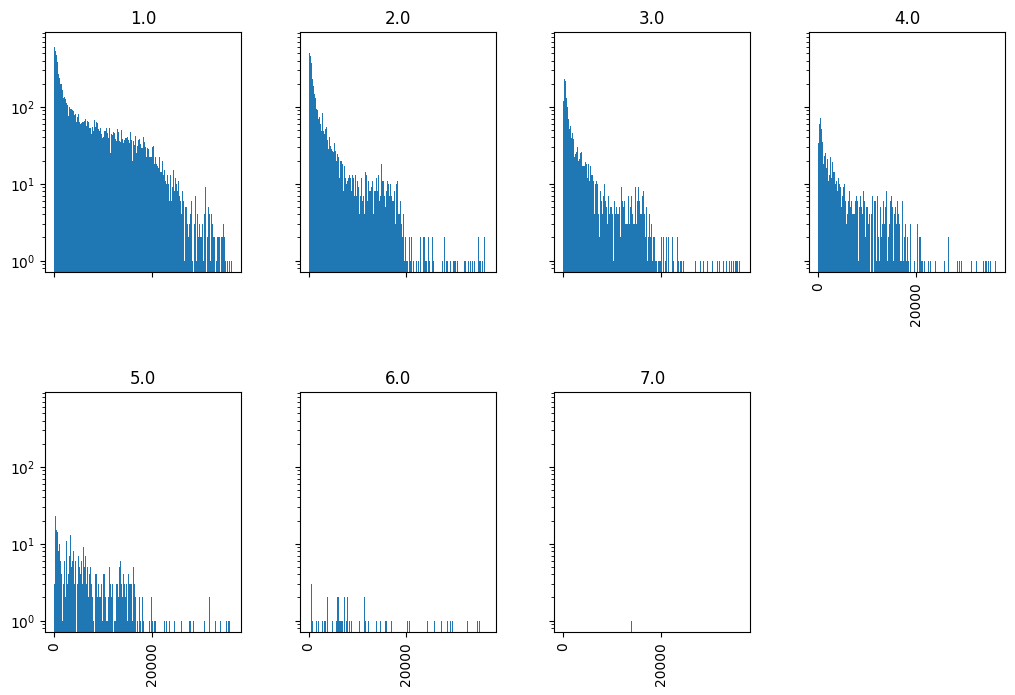

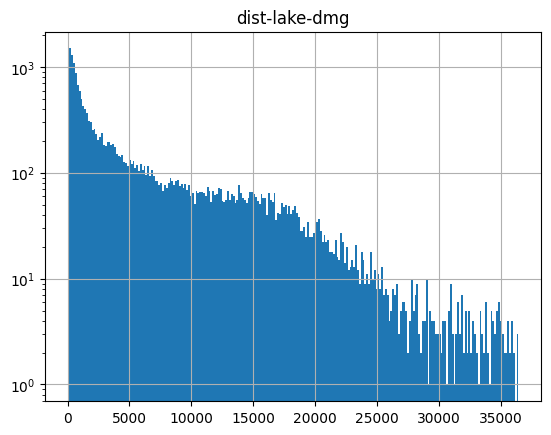

In [65]:
max_dist = gdf_DfromSGL["dist-lake-dmg"].max()
fig, ax = plt.subplots(figsize =(12, 8))
gdf_DfromSGL.hist(column = "dist-lake-dmg", bins = list(np.arange(0, max_dist, 300 / 2)), by = "dmg", ax = ax, sharex = True, log = True, sharey = True, layout = (2, 4))
gdf_DfromSGL.hist(column = "dist-lake-dmg", bins = list(np.arange(0, max_dist, 300 / 2)), log = True)

In [59]:
def ckdnearest_SGLfromD(gdSGL, gdD):
    dmg_cats = sorted(gdD["attribute"].unique())
    gdSGL = gdSGL.reset_index(drop=True)
    nSGL = np.array(list(gdSGL["centroids"].apply(lambda x: (x.x, x.y))))
    gdf_cats = []
    for cat in dmg_cats:
        gdD_cat = gdD[gdD["attribute"] == cat].reset_index(drop=True)
        nD_cat = np.array(list(gdD_cat["centroids"].apply(lambda x: (x.x, x.y))))
        Dtree = cKDTree(nD_cat)
        dist, idx = Dtree.query(nSGL, k=1)
    
        gdD_cat_nearest = gdD_cat.iloc[idx].rename(columns={"geometry" : "dmg-geometry", "attribute" : "dmg", "centroids" : "dmg-centroids"}).reset_index(drop=True)

        gdf_cat = pd.concat(
            [
                gdSGL.reset_index(drop=True),
                pd.Series(dist, name='dist-dmg-lake'),
                gdD_cat_nearest,
                
            ], 
            axis=1)
        gdf_cats.append(gdf_cat)

    return gdf_cats

IndexError: list index out of range

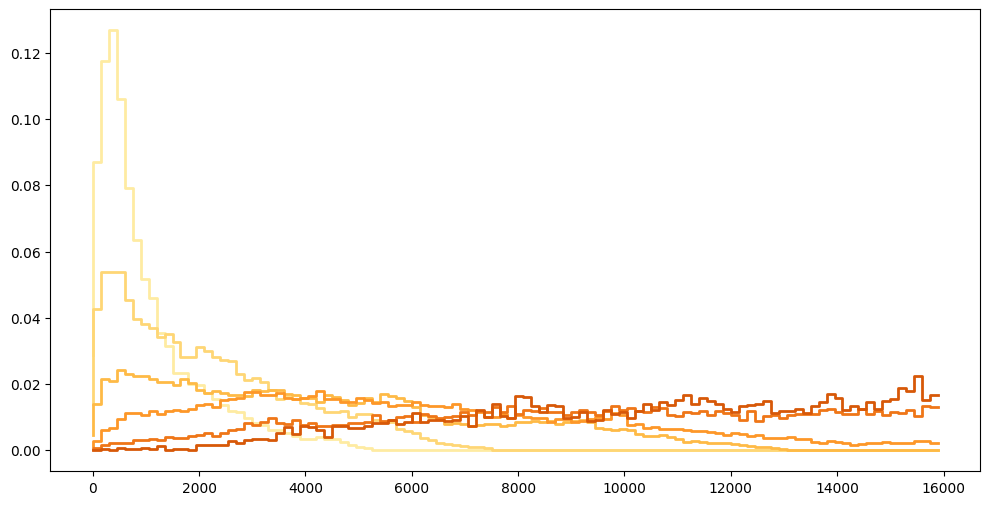

In [58]:
dmg_cats = sorted(dmgs[2]["data"]["attribute"].unique())
bin_limits = np.arange(0, max(gdf_SGLfromD[2]["dist-dmg-lake"]), 300/2)

fig, ax = plt.subplots(figsize = (12, 6))
for i_cat, cat in enumerate(dmg_cats):
    count, division = np.histogram(gdf_SGLfromD[i_cat][gdf_SGLfromD[i_cat]["dmg"] == cat]["dist-dmg-lake"], bins = bin_limits)
    count_sum = np.array(count).sum()
    if count_sum == 0:
        continue
    ax.step(division[:-1], np.array(count) / count_sum, lw = 2, label = f"{cat}", color = cmap((i_cat / len(dmg_cats)) * 0.8 + 0.2))
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend()
plt.show()

In [56]:
gdf = gpd.read_file(r"D:\OneDrive\02_Standards\[Code]\01_Projects\ASRP_Antarctic-Remote-Sensing-1\202_OutputSGL\shackleton_sgl_20191201_20200331\L8S2_20191201_20200331_drain.shp")

In [ ]:
gdf_SGLfromD = ckdnearest_SGLfromD(lakeextents[0]["data"], dmgs[0]["data"])